In [92]:
import numpy as np
import scipy
import scipy.sparse
from sklearn.datasets import fetch_20newsgroups
import gensim
from collections import Counter
import heapq
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline

In [79]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/tylorn/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [80]:
english_stopwords = set(stopwords.words('english'))

In [50]:
def trivial_p_dwt_processor(p_dwt):
    pass

def create_frac_of_max_p_dwt_processor(frac_size):
    def fun(p_dwt):
        maximums = np.max(p_dwt, axis=1)
        p_dwt[p_dwt < frac_size * maximums[:, np.newaxis]] = 0.
        p_dwt /= (np.sum(p_dwt, axis=1)[:, np.newaxis] + 1e-10)
    return fun

In [15]:
def perform_e_step_update(freq_matrix, docptr, phi_matrix, theta_matrix, params):
    block_size = params.get('block_size', 1)
    p_dwt_processor = params.get('p_dwt_processor', lambda x: None)
    
    D, W = freq_matrix.shape
    T = phi_matrix.shape[0]
    n_wt, n_dt = np.zeros((W, T)), np.zeros((D, T))
    transposed_phi_matrix = np.transpose(phi_matrix)
    
    indices = freq_matrix.indices
    indptr = freq_matrix.indptr
    data = freq_matrix.data
    
    for block_num in xrange((D + block_size - 1) / block_size):
        block_start = block_num * block_size
        block_finish = min(D, block_start + block_size)
        ind_start, ind_finish = indptr[block_start], indptr[block_finish]
        
        datas = data[ind_start:ind_finish]
        words = indices[ind_start:ind_finish]
        docs = docptr[ind_start:ind_finish]
        
        p_dwt = transposed_phi_matrix[words] * theta_matrix[docs, :]
        p_dwt /= (np.sum(p_dwt, axis=1)[:, np.newaxis] + 1e-10)
        p_dwt_processor(p_dwt)
        p_dwt *= datas[:, np.newaxis]
        
        for doc_num in xrange(block_start, block_finish):
            doc_start, doc_finish = indptr[doc_num], indptr[doc_num + 1]
            doc_p_dwt = p_dwt[(doc_start - ind_start):(doc_finish - ind_start), :]
            n_dt[doc_num, :] += np.sum(doc_p_dwt, axis=0)
            n_wt[indices[doc_start:doc_finish], :] += doc_p_dwt

    return n_wt, n_dt

In [189]:
def perform_obg_e_step_update(freq_matrix, docptr, phi_matrix, theta_matrix, params):
    block_size = params.get('block_size', 1)
    percentile = params.get('percentile', 99)
    return_gamma = params.get('return_gamma', False)
    
    D, W = freq_matrix.shape
    T = phi_matrix.shape[0]
    n_wt, n_dt = np.zeros((W, T)), np.zeros((D, T))
    alpha_wt, beta_wt = np.zeros((W, T)), np.zeros((W, T))
    transposed_phi_matrix = np.transpose(phi_matrix)
    
    indices = freq_matrix.indices
    indptr = freq_matrix.indptr
    data = freq_matrix.data
    
    for block_num in xrange((D + block_size - 1) / block_size):
        block_start = block_num * block_size
        block_finish = min(D, block_start + block_size)
        ind_start, ind_finish = indptr[block_start], indptr[block_finish]
        
        datas = data[ind_start:ind_finish]
        words = indices[ind_start:ind_finish]
        docs = docptr[ind_start:ind_finish]
        
        p_dwt = transposed_phi_matrix[words] * theta_matrix[docs, :]
        p_dwt /= (np.sum(p_dwt, axis=1)[:, np.newaxis] + 1e-10)
        
        alpha_dwt = np.log(1. - p_dwt) * datas[:, np.newaxis]
        beta_dwt = np.log(1. + p_dwt) * datas[:, np.newaxis]
        n_dwt = p_dwt * datas[:, np.newaxis]
        
        for doc_num in xrange(block_start, block_finish):
            doc_start, doc_finish = indptr[doc_num], indptr[doc_num + 1]
            
            doc_n_dwt = n_dwt[(doc_start - ind_start):(doc_finish - ind_start), :]
            doc_alpha_dwt = alpha_dwt[(doc_start - ind_start):(doc_finish - ind_start), :]
            doc_beta_dwt = beta_dwt[(doc_start - ind_start):(doc_finish - ind_start), :]
            
            n_dt[doc_num, :] += np.sum(doc_n_dwt, axis=0)
            positions = indices[doc_start:doc_finish]
            n_wt[positions, :] += doc_n_dwt
            alpha_wt[positions, :] += doc_alpha_dwt
            beta_wt[positions, :] += doc_beta_dwt
    
    beta_t = np.sum(beta_wt, axis=0)
    gamma_wt = alpha_wt + transposed_phi_matrix * (1. - transposed_phi_matrix) * (beta_t[np.newaxis, :] - beta_wt)
    bound = np.percentile(gamma_wt[gamma_wt < 0], percentile)
    n_wt[gamma_wt > bound] = 0.
    
    
    plt.hist(np.log(- gamma_wt[gamma_wt < 0]).flatten(), bins=100)
    plt.show()
    
    if return_gamma:
        return n_wt, n_dt, gamma_wt
    else:
        return n_wt, n_dt

In [46]:
def launch_em(
    freq_matrix, 
    phi_matrix,
    theta_matrix,
    logger,
    regularizations_list,
    params_list,
    iters_count=100
):
    phi_matrix = np.array(phi_matrix)
    theta_matrix = np.array(theta_matrix)
    docptr = []
    indptr = freq_matrix.indptr
    for doc_num in xrange(D):
        docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
    docptr = np.array(docptr)
    
    for it in xrange(iters_count):
        print it
        n_wt, n_dt = params_list[it]['method'](freq_matrix, docptr, phi_matrix, theta_matrix, params_list[it])
        r_wt, r_dt = regularizations_list[it](n_wt, n_dt, phi_matrix, theta_matrix)
        n_wt = np.maximum(n_wt + r_wt, 0)
        n_dt = np.maximum(n_dt + r_dt, 0)
        n_wt /= np.sum(n_wt, axis=0)
        n_dt /= np.sum(n_dt, axis=1)[:, np.newaxis]
        phi_matrix = np.transpose(n_wt)
        theta_matrix = n_dt
        logger(freq_matrix, docptr, phi_matrix, theta_matrix)
        
    return phi_matrix, theta_matrix

In [106]:
def trivial_regularization(n_wt, n_dt, phi_matrix, theta_matrix):
    return 0., 0.

def calculate_decorr(phi_matrix):
    aggr_phi = np.sum(phi_matrix, axis=1)
    return np.sum(phi_matrix * (aggr_phi[:, np.newaxis] - phi_matrix))

def create_reg_decorr_naive(tau):
    def fun (n_wt, n_dt, phi_matrix, theta_matrix):
        aggr_phi = np.sum(phi_matrix, axis=1)
        return - tau * np.transpose(phi_matrix * (aggr_phi[:, np.newaxis] - phi_matrix)), -0.1
    return fun

def create_reg_decorr_unbiased(tau):
    def fun (n_wt, n_dt, phi_matrix, theta_matrix):
        tmp_phi =  n_wt / np.sum(n_wt, axis=0)
        aggr_phi = np.sum(tmp_phi, axis=0)
        return - tau * tmp_phi * (aggr_phi[np.newaxis, :] - tmp_phi), -0.1
    return fun

def calculate_likelihood(freq_matrix, docptr, phi_matrix, theta_matrix, block_size=1):
    D, W = freq_matrix.shape
    T = phi_matrix.shape[0]
    transposed_phi_matrix = np.transpose(phi_matrix)
    
    indices = freq_matrix.indices
    indptr = freq_matrix.indptr
    data = freq_matrix.data
    
    res = 0.
    for block_num in xrange((D + block_size - 1) / block_size):
        block_start = block_num * block_size
        block_finish = min(D, block_start + block_size)
        ind_start, ind_finish = indptr[block_start], indptr[block_finish]
        
        datas = data[ind_start:ind_finish]
        words = indices[ind_start:ind_finish]
        docs = docptr[ind_start:ind_finish]
        
        p_dwt = transposed_phi_matrix[words] * theta_matrix[docs, :]
        res += np.sum(np.log(np.sum(p_dwt, axis=1) + 1e-10) * datas)
    
    return res


def create_decorr_logger(tau):
    def fun(freq_matrix, docptr, phi_matrix, theta_matrix):
        likelihood = calculate_likelihood(freq_matrix, docptr, phi_matrix, theta_matrix, 50)
        decorr = calculate_decorr(phi_matrix)
        print 'L', likelihood
        print 'decorr', decorr
        print 'L + tau R', likelihood - tau * decorr
        non_zeros = np.sum(phi_matrix > 1e-20)
        size = phi_matrix.shape[0] * phi_matrix.shape[1]
        print 'Zeros', non_zeros, '   ', round(1. * non_zeros / size, 2)
    return fun

In [164]:
def prepare_dataset(dataset):
    # remove stopwords
    occurences = Counter()
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        for token in set(tokens):
            occurences[token] += 1
        if i % 500 == 0:
            print 'Processed: ', i, 'from', len(dataset.data)
    
    row, col, data = [], [], []
    token_2_num = {}
    for i, doc in enumerate(dataset.data):
        tokens = gensim.utils.lemmatize(doc)
        cnt = Counter()
        for token in tokens:
            word = token.split('/')[0]
            if word not in english_stopwords and 10 <= occurences[token] < len(dataset.data) / 2:
                if token not in token_2_num:
                    token_2_num[token] = len(token_2_num)
                cnt[token_2_num[token]] += 1
        for w, c in cnt.iteritems():
            row.append(i)
            col.append(w)
            data.append(c)
        
    num_2_token = {
        v: k
        for k, v in token_2_num.iteritems()
    }
    print len(data)
    return scipy.sparse.csr_matrix((data, (row, col))), token_2_num, num_2_token


In [165]:
dataset = fetch_20newsgroups(
    subset='train',
    categories=['sci.electronics', 'sci.med', 'sci.space'],
    remove=('headers', 'footers', 'quotes')
)

In [166]:
%%time
origin_freq_matrix, token_2_num, num_2_token = prepare_dataset(dataset)

Processed:  0 from 1778
Processed:  500 from 1778
Processed:  1000 from 1778
Processed:  1500 from 1778
73610
CPU times: user 1min 26s, sys: 4 ms, total: 1min 26s
Wall time: 1min 26s


In [177]:
# design experiment

D, W = origin_freq_matrix.shape
T = 5

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]


DECORR_TAU = 1e3

trivial_regularization = trivial_regularization
decorr_regularization = create_reg_decorr_unbiased(DECORR_TAU)

small_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': create_frac_of_max_p_dwt_processor(0.)
}
big_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': create_frac_of_max_p_dwt_processor(0.5)
}
no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}

regularizations_list = np.zeros(50, dtype=object)
params_list = np.zeros(50, dtype=object)

regularizations_list[:30] = decorr_regularization
regularizations_list[30:] = trivial_regularization
params_list[:30] = small_selection_params
params_list[30:40] = big_selection_params
params_list[40:] = no_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    logger=create_decorr_logger(DECORR_TAU),
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=50
)

0
L -820129.091613
decorr 4.99198710322
L + tau R -825121.078716
Zeros 11135     1.0
1
L -818111.173457
decorr 4.99199159614
L + tau R -823103.165054
Zeros 11135     1.0
2
L -816090.921891
decorr 4.99187497996
L + tau R -821082.796871
Zeros 11135     1.0
3
L -813792.000793
decorr 4.99164953633
L + tau R -818783.65033
Zeros 11135     1.0
4
L -811121.813238
decorr 4.99131671641
L + tau R -816113.129954
Zeros 11135     1.0
5
L -808139.705307
decorr 4.99089132281
L + tau R -813130.596629
Zeros 11135     1.0
6
L -805022.631434
decorr 4.99040986941
L + tau R -810013.041303
Zeros 11135     1.0
7
L -801959.289642
decorr 4.9899103415
L + tau R -806949.199983
Zeros 11135     1.0
8
L -799079.194191
decorr 4.98941516976
L + tau R -804068.60936
Zeros 11135     1.0
9
L -796458.783075
decorr 4.9889476369
L + tau R -801447.730712
Zeros 11135     1.0
10
L -794119.447111
decorr 4.98853718448
L + tau R -799107.984295
Zeros 11135     1.0
11
L -792052.796555
decorr 4.98819207411
L + tau R -797040.988629
Ze

In [172]:
# design experiment

D, W = origin_freq_matrix.shape
T = 5

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]


DECORR_TAU = 1e3

trivial_regularization = trivial_regularization
decorr_regularization = create_reg_decorr_unbiased(DECORR_TAU)

small_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': create_frac_of_max_p_dwt_processor(0.)
}
big_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': create_frac_of_max_p_dwt_processor(0.5)
}
no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}

regularizations_list = np.zeros(50, dtype=object)
params_list = np.zeros(50, dtype=object)

regularizations_list[:50] = trivial_regularization
params_list[:50] = no_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    logger=create_decorr_logger(DECORR_TAU),
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=50
)

0
L -820130.324989
decorr 4.99198902245
L + tau R -825122.314011
Zeros 11135     1.0
1
L -818134.945369
decorr 4.99199206386
L + tau R -823126.937433
Zeros 11135     1.0
2
L -816143.252192
decorr 4.99187356492
L + tau R -821135.125757
Zeros 11135     1.0
3
L -813868.70032
decorr 4.99164514986
L + tau R -818860.34547
Zeros 11135     1.0
4
L -811208.079829
decorr 4.99130649012
L + tau R -816199.386319
Zeros 11135     1.0
5
L -808210.26557
decorr 4.99086970024
L + tau R -813201.13527
Zeros 11135     1.0
6
L -805051.12136
decorr 4.99036885759
L + tau R -810041.490218
Zeros 11135     1.0
7
L -801923.213602
decorr 4.98984139522
L + tau R -806913.054997
Zeros 11135     1.0
8
L -798961.070432
decorr 4.98930999273
L + tau R -803950.380424
Zeros 11135     1.0
9
L -796239.748427
decorr 4.9887968683
L + tau R -801228.545295
Zeros 11135     1.0
10
L -793781.881953
decorr 4.98833114008
L + tau R -798770.213093
Zeros 11135     1.0
11
L -791589.905499
decorr 4.98792634533
L + tau R -796577.831845
Zero

In [114]:
for t in xrange(T):
    top = heapq.nlargest(20, range(W), key=lambda w: phi[t, w])
    print t
    for w in top:
        print '\t', '\t\t'.join(num_2_token[w].split('/')), phi[t, w]

0
	cx		NN 0.0107606842426
	hz		NN 0.00922447622453
	qs		NN 0.00751548419907
	ck		NN 0.0068168083012
	pl		NN 0.00670915846499
	lk		NN 0.00633106602575
	uw		NN 0.00620873617363
	tl		NN 0.00550949929327
	zd		NN 0.00532582256722
	chz		NN 0.00511557125899
	mc		NN 0.00509568928793
	mv		NN 0.00488119572777
	mw		NN 0.00486344046315
	ww		VB 0.00455398716083
	md		NN 0.00409549744592
	sk		NN 0.00393135796019
	mt		NN 0.00373785503807
	wt		NN 0.0037280096487
	pu		NN 0.00362129647177
	cj		NN 0.00351676776471
1
	ax		NN 0.8181095055
	max		NN 0.058864728996
	pl		NN 0.00673374333383
	ei		NN 0.0064154372943
	tm		NN 0.00528157244335
	giz		NN 0.0051968862251
	bhj		NN 0.0051291177358
	ey		NN 0.00384944944369
	qax		NN 0.00297476644208
	wm		VB 0.0029291661028
	gk		NN 0.00241663140198
	kn		NN 0.00231751970805
	bxn		NN 0.00227581446536
	qq		NN 0.00214950874298
	tq		NN 0.00214789634754
	tg		NN 0.00174239243678
	bj		NN 0.00172994568969
	wt		NN 0.00141210975259
	yf		NN 0.00141150426563
	ez		NN 0.00127898947466
2
	

In [173]:
docptr = []
indptr = origin_freq_matrix.indptr
for doc_num in xrange(D):
    docptr.extend([doc_num] * (indptr[doc_num + 1] - indptr[doc_num]))
docptr = np.array(docptr)

_, _, gamma_wt = perform_obg_e_step_update(origin_freq_matrix, docptr, phi, theta, {'block_size': 50, 'return_gamma': True})

In [174]:
for t in xrange(T):
    top = heapq.nlargest(20, range(W), key=lambda w: - gamma_wt[w, t])
    print t
    for w in top:
        #print num_2_token[w].split('/')[0]
        print '\t', '\t\t'.join(num_2_token[w].split('/')), - gamma_wt[w, t]

0
	edu		NN 8564.36217027
	nasa		NN 3190.96532656
	com		NN 2757.36680011
	space		NN 1982.84022061
	gov		NN 1540.23644999
	pitt		NN 1266.01992897
	intellect		NN 1197.62539326
	skepticism		NN 1195.51258367
	jxp		NN 1182.04833884
	chastity		NN 1182.04833884
	geb		JJ 1164.75348173
	cadre		NN 1164.75348173
	dsl		NN 1164.75348173
	shameful		JJ 1164.75348173
	surrender		VB 1164.75348173
	cs		NN 849.023973048
	pub		NN 844.895059329
	ftp		NN 816.953466977
	gif		NN 761.480645123
	anonymous		JJ 729.549520602
1
	cancer		NN 2076.88641653
	health		NN 1795.44655752
	aids		NN 1376.02944265
	disease		NN 1271.65409507
	child		NN 1246.95444269
	use		NN 1049.63937329
	medical		JJ 1017.13123865
	number		NN 955.165195502
	clinical		JJ 899.752167556
	page		NN 833.524744923
	april		NN 827.643243117
	report		VB 810.060087456
	year		NN 792.949816491
	volume		NN 791.786527592
	case		NN 764.940694728
	newsletter		NN 714.096266712
	patient		NN 699.026558678
	center		NN 694.861964928
	adult		NN 678.012476739
	safety

0
L -820129.091744
decorr 4.99198710326
L + tau R -825121.078847
Zeros 11135     1.0
1
L -818111.173474
decorr 4.99199159384
L + tau R -823103.165068
Zeros 11135     1.0
2
L -816090.921796
decorr 4.99187497768
L + tau R -821082.796774
Zeros 11135     1.0
3
L -813792.000583
decorr 4.99164953404
L + tau R -818783.650117
Zeros 11135     1.0
4
L -811121.812905
decorr 4.99131671405
L + tau R -816113.129619
Zeros 11135     1.0
5
L -808139.704861
decorr 4.99089132035
L + tau R -813130.596181
Zeros 11135     1.0
6
L -805022.630912
decorr 4.99040986683
L + tau R -810013.040779
Zeros 11135     1.0
7
L -801959.289089
decorr 4.98991033879
L + tau R -806949.199427
Zeros 11135     1.0
8
L -799079.193635
decorr 4.98941516691
L + tau R -804068.608802
Zeros 11135     1.0
9
L -796458.78254
decorr 4.98894763393
L + tau R -801447.730174
Zeros 11135     1.0
10
L -794119.446614
decorr 4.98853718137
L + tau R -799107.983796
Zeros 11135     1.0
11
L -792052.796105
decorr 4.9881920709
L + tau R -797040.988176


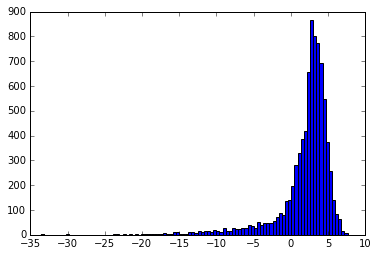

L -779914.511758
decorr 4.98707313065
L + tau R -784901.584889
Zeros 8195     0.74
31


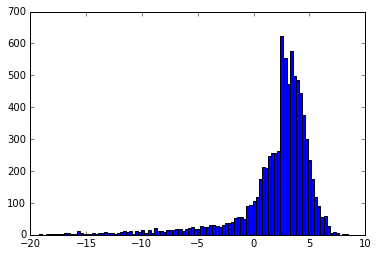

L -779774.486352
decorr 4.98708552445
L + tau R -784761.571877
Zeros 8131     0.73
32


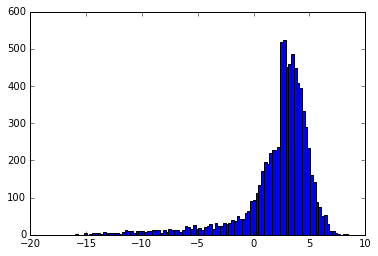

L -779636.057579
decorr 4.98709618456
L + tau R -784623.153764
Zeros 8067     0.72
33


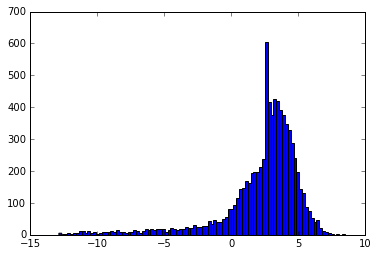

L -779490.632813
decorr 4.98710742274
L + tau R -784477.740235
Zeros 8009     0.72
34


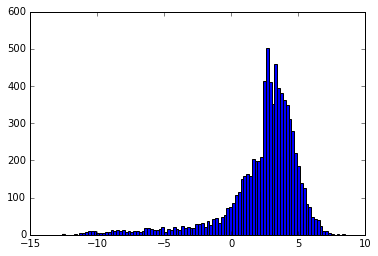

L -779343.795948
decorr 4.9871159957
L + tau R -784330.911943
Zeros 7956     0.71
35


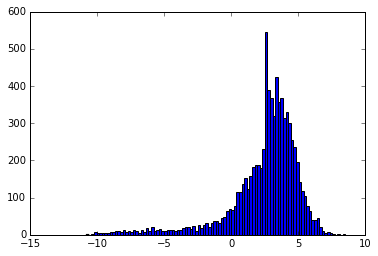

L -779202.339957
decorr 4.98711755466
L + tau R -784189.457512
Zeros 7897     0.71
36


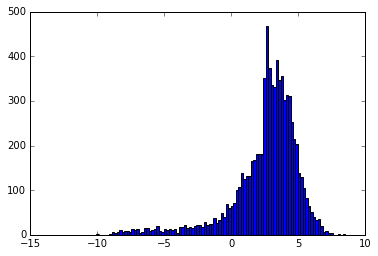

L -779089.682718
decorr 4.98712010953
L + tau R -784076.802828
Zeros 7846     0.7
37


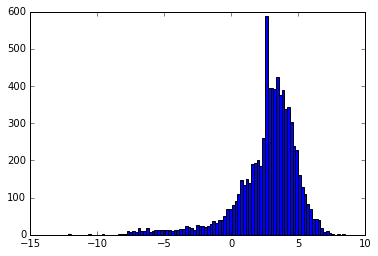

L -778992.777392
decorr 4.98712387556
L + tau R -783979.901268
Zeros 7799     0.7
38


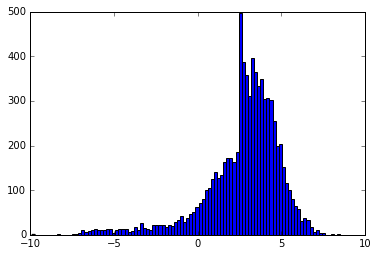

L -778903.693672
decorr 4.98712690807
L + tau R -783890.82058
Zeros 7751     0.7
39


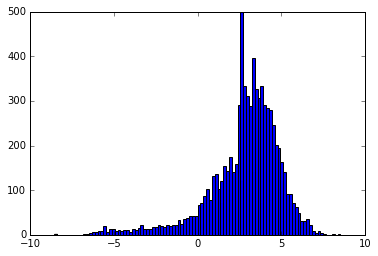

L -778821.49363
decorr 4.98712957046
L + tau R -783808.6232
Zeros 7708     0.69
40


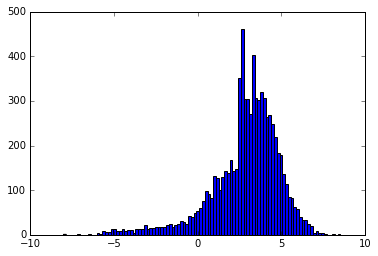

L -778746.616468
decorr 4.98713113186
L + tau R -783733.7476
Zeros 7665     0.69
41


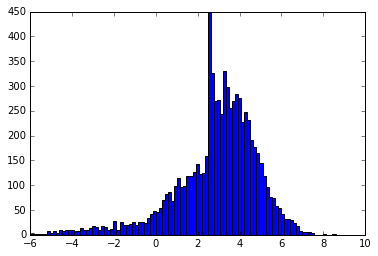

L -778677.309521
decorr 4.98713156461
L + tau R -783664.441085
Zeros 7622     0.68
42


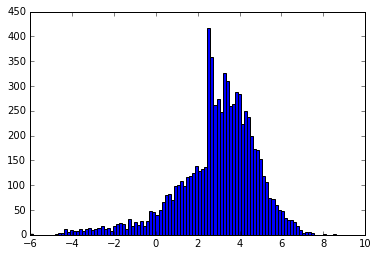

L -778614.38728
decorr 4.98713148371
L + tau R -783601.518764
Zeros 7580     0.68
43


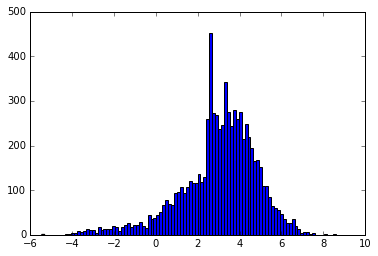

L -778557.246991
decorr 4.98713101183
L + tau R -783544.378003
Zeros 7539     0.68
44


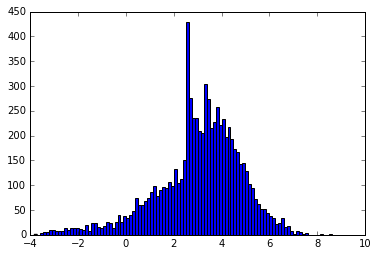

L -778504.58566
decorr 4.98713022794
L + tau R -783491.715888
Zeros 7500     0.67
45


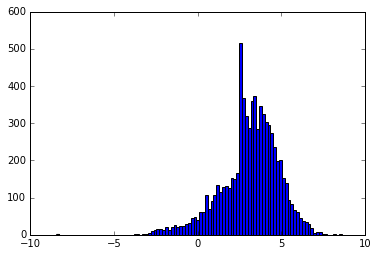

L -778458.576858
decorr 4.98712986778
L + tau R -783445.706726
Zeros 7461     0.67
46


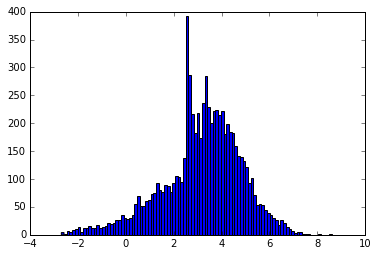

L -778417.697367
decorr 4.98712885007
L + tau R -783404.826217
Zeros 7423     0.67
47


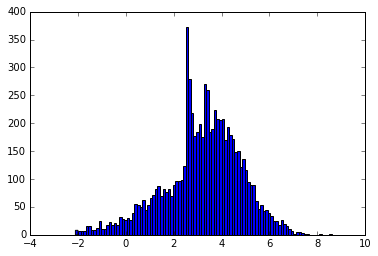

L -778379.312253
decorr 4.98712537189
L + tau R -783366.437625
Zeros 7383     0.66
48


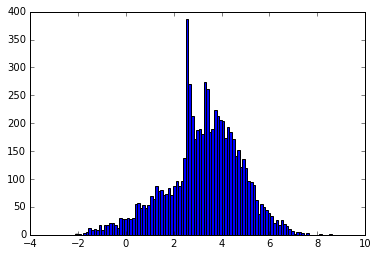

L -778348.874209
decorr 4.98712237639
L + tau R -783335.996586
Zeros 7346     0.66
49


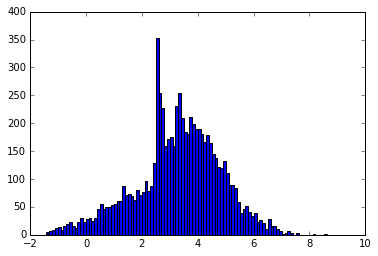

L -778324.065223
decorr 4.98711695653
L + tau R -783311.18218
Zeros 7309     0.66
50


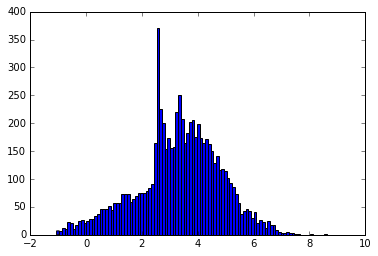

L -778303.087319
decorr 4.98711138779
L + tau R -783290.198707
Zeros 7272     0.65
51


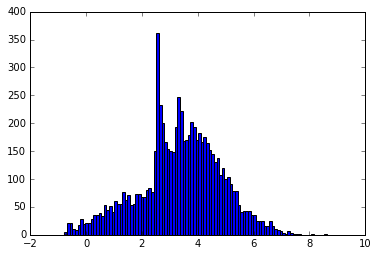

L -778286.232023
decorr 4.98710499364
L + tau R -783273.337016
Zeros 7235     0.65
52


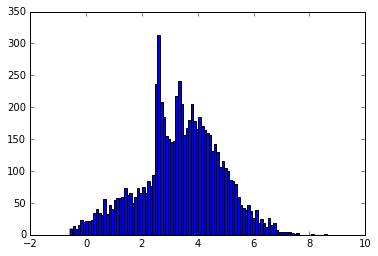

L -778271.950406
decorr 4.98709711425
L + tau R -783259.04752
Zeros 7198     0.65
53


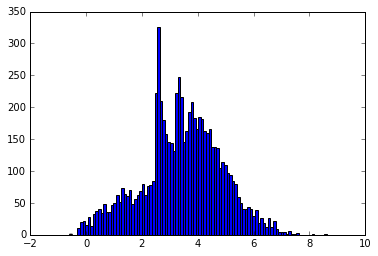

L -778261.261574
decorr 4.98708857831
L + tau R -783248.350153
Zeros 7162     0.64
54


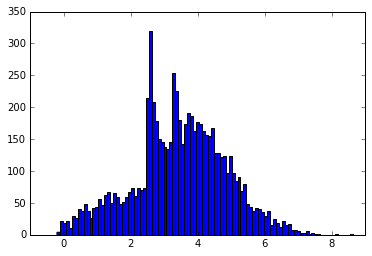

L -778252.992542
decorr 4.98707818881
L + tau R -783240.07073
Zeros 7126     0.64
55


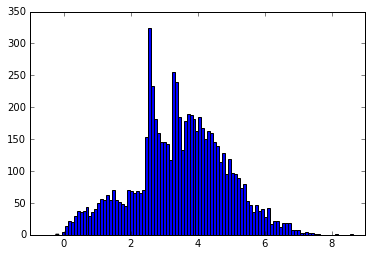

L -778249.213294
decorr 4.98706832113
L + tau R -783236.281616
Zeros 7090     0.64
56


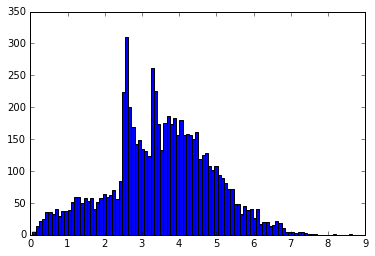

L -778245.308189
decorr 4.98705204895
L + tau R -783232.360238
Zeros 7054     0.63
57


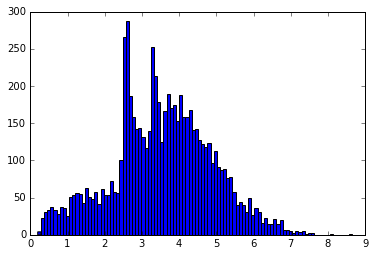

L -778246.157459
decorr 4.9870359014
L + tau R -783233.19336
Zeros 7018     0.63
58


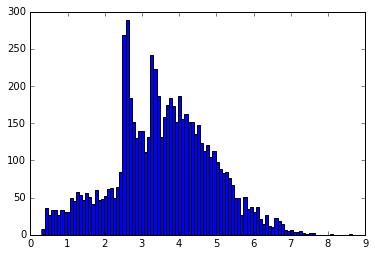

L -778248.52253
decorr 4.98701565328
L + tau R -783235.538183
Zeros 6982     0.63
59


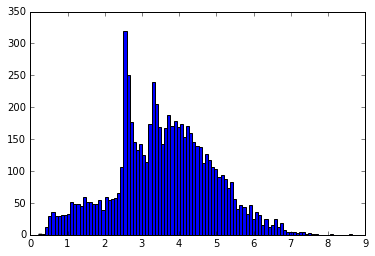

L -778253.528422
decorr 4.98699653129
L + tau R -783240.524954
Zeros 6947     0.62
60


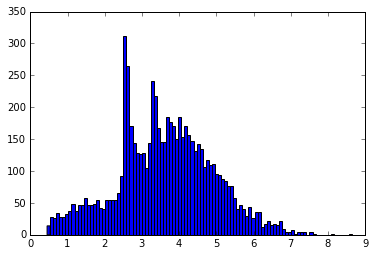

L -778261.922903
decorr 4.98697863011
L + tau R -783248.901533
Zeros 6912     0.62
61


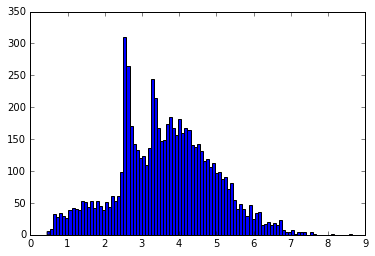

L -778266.729684
decorr 4.98695410598
L + tau R -783253.68379
Zeros 6877     0.62
62


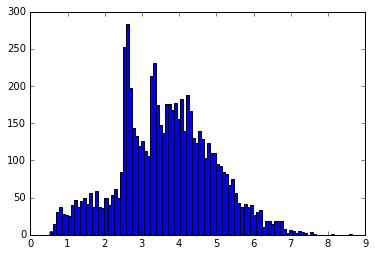

L -778286.499288
decorr 4.98692863485
L + tau R -783273.427923
Zeros 6842     0.61
63


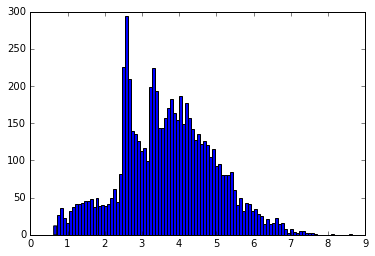

L -778293.512807
decorr 4.98690314816
L + tau R -783280.415955
Zeros 6807     0.61
64


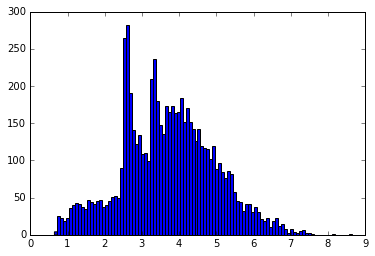

L -778309.218915
decorr 4.98687347032
L + tau R -783296.092386
Zeros 6772     0.61
65


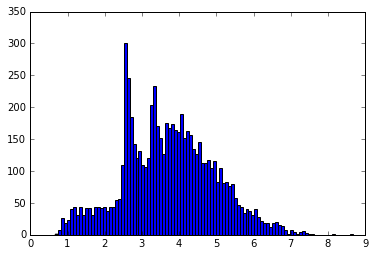

L -778327.127593
decorr 4.98684303194
L + tau R -783313.970625
Zeros 6738     0.61
66


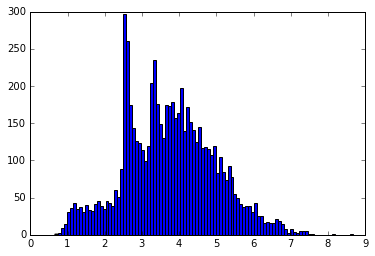

L -778345.728371
decorr 4.98681501362
L + tau R -783332.543384
Zeros 6704     0.6
67


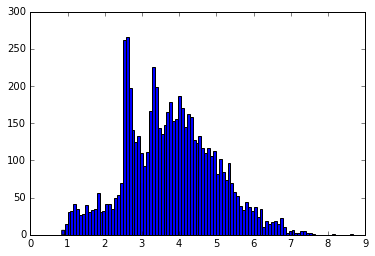

L -778369.680287
decorr 4.98678777201
L + tau R -783356.468059
Zeros 6670     0.6
68


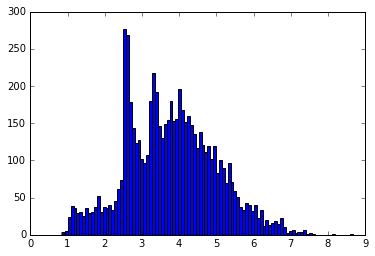

L -778420.238896
decorr 4.98676323872
L + tau R -783407.002135
Zeros 6636     0.6
69


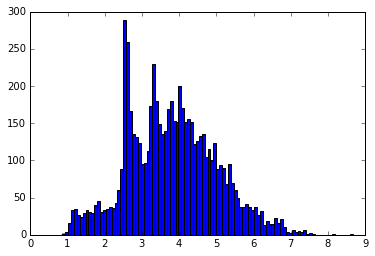

L -778443.020327
decorr 4.98673411642
L + tau R -783429.754444
Zeros 6602     0.59
70


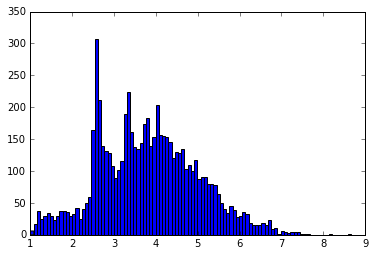

L -778479.063459
decorr 4.98670864876
L + tau R -783465.772108
Zeros 6568     0.59
71


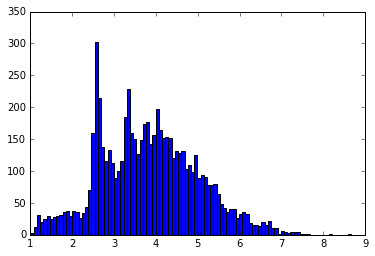

L -778509.883072
decorr 4.98668697734
L + tau R -783496.570049
Zeros 6535     0.59
72


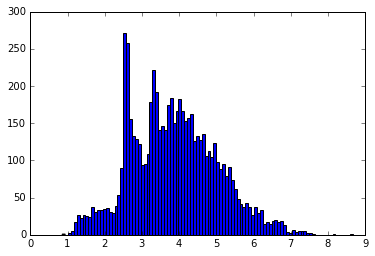

L -778540.545276
decorr 4.98665583076
L + tau R -783527.201107
Zeros 6502     0.58
73


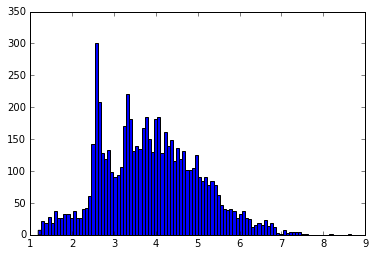

L -778584.342646
decorr 4.9866298102
L + tau R -783570.972456
Zeros 6469     0.58
74


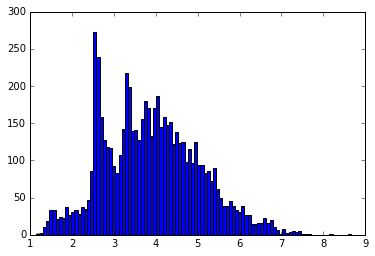

L -778629.81088
decorr 4.98660048776
L + tau R -783616.411368
Zeros 6436     0.58
75


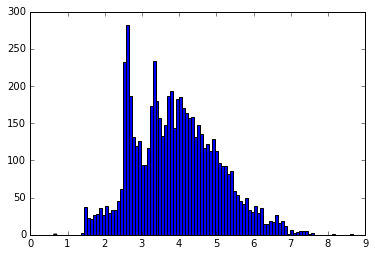

L -778695.079655
decorr 4.98657912682
L + tau R -783681.658782
Zeros 6403     0.58
76


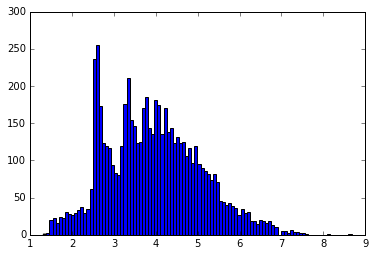

L -778753.629494
decorr 4.98655315242
L + tau R -783740.182646
Zeros 6370     0.57
77


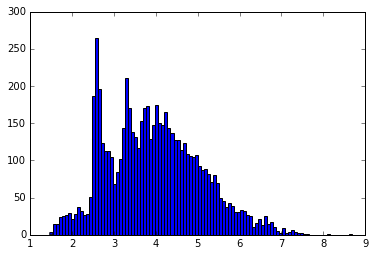

L -778812.58588
decorr 4.98652961759
L + tau R -783799.115498
Zeros 6338     0.57
78


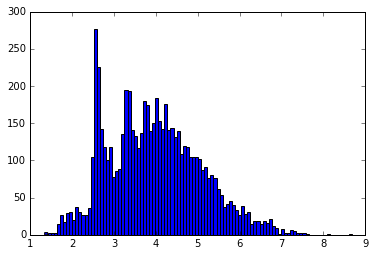

L -778865.55685
decorr 4.98650035111
L + tau R -783852.057201
Zeros 6306     0.57
79


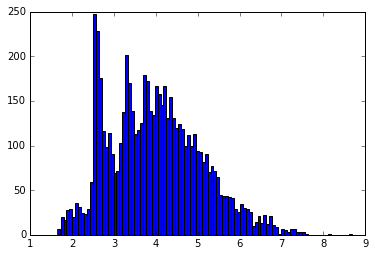

L -778949.327673
decorr 4.98647554389
L + tau R -783935.803217
Zeros 6274     0.56
80


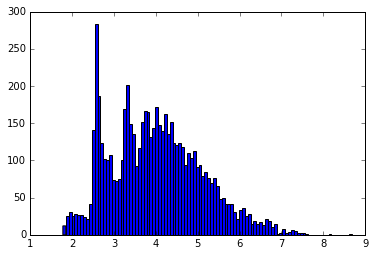

L -779058.213685
decorr 4.98645162568
L + tau R -784044.665311
Zeros 6242     0.56
81


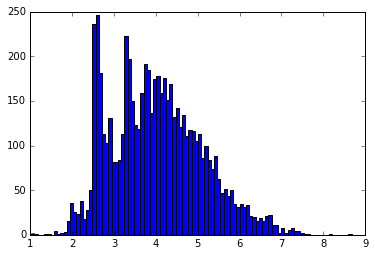

L -779096.813141
decorr 4.98643810649
L + tau R -784083.251248
Zeros 6210     0.56
82


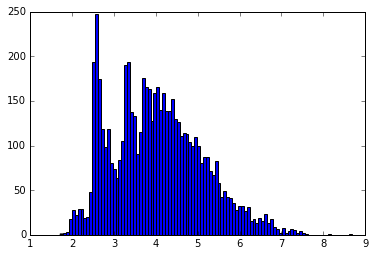

L -779188.966037
decorr 4.98640686669
L + tau R -784175.372903
Zeros 6178     0.55
83


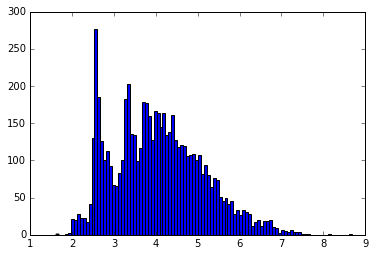

L -779247.299832
decorr 4.98637871963
L + tau R -784233.678552
Zeros 6147     0.55
84


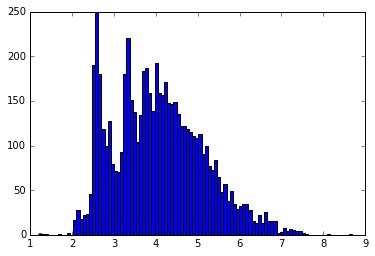

L -779323.281939
decorr 4.98635510145
L + tau R -784309.63704
Zeros 6116     0.55
85


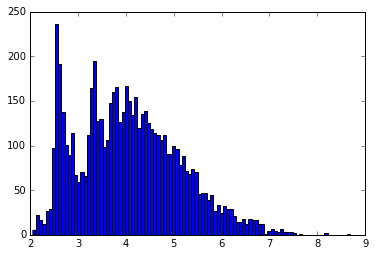

L -779443.493143
decorr 4.98632291896
L + tau R -784429.816062
Zeros 6085     0.55
86


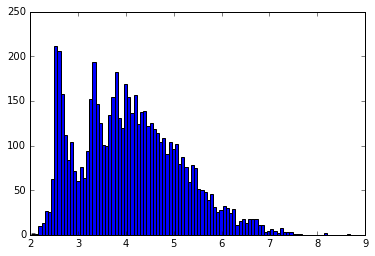

L -779520.438723
decorr 4.98630099202
L + tau R -784506.739715
Zeros 6054     0.54
87


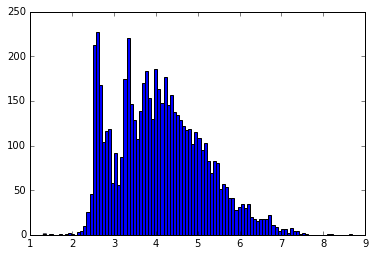

L -779619.632639
decorr 4.98627953853
L + tau R -784605.912177
Zeros 6023     0.54
88


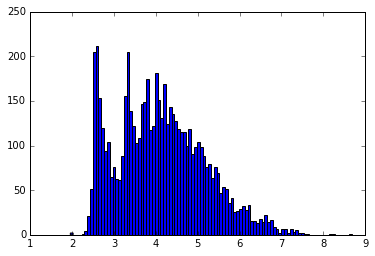

L -779762.2567
decorr 4.98624540297
L + tau R -784748.502103
Zeros 5992     0.54
89


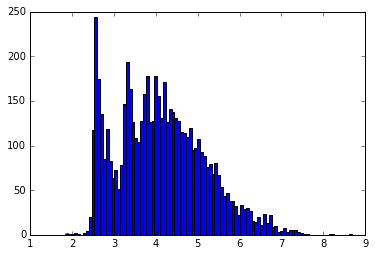

L -779876.268843
decorr 4.98623162053
L + tau R -784862.500463
Zeros 5962     0.54
90


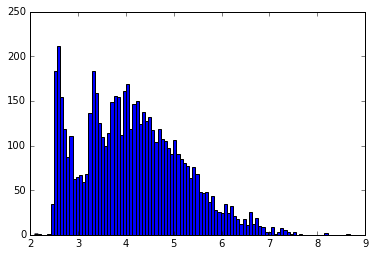

L -780071.379632
decorr 4.98621347462
L + tau R -785057.593107
Zeros 5932     0.53
91


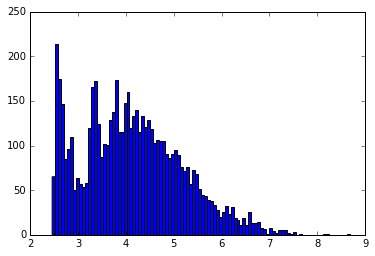

L -780314.6151
decorr 4.98618910001
L + tau R -785300.8042
Zeros 5902     0.53
92


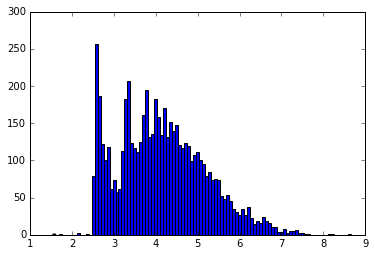

L nan
decorr 4.98617187418
L + tau R nan
Zeros 5872     0.53
93


IndexError: cannot do a non-empty take from an empty axes.

In [190]:
# design experiment

D, W = origin_freq_matrix.shape
T = 5

np.random.seed(42)

phi_matrix = np.random.uniform(size=(T, W)).astype(np.float64)
phi_matrix /= np.sum(phi_matrix, axis=1)[:, np.newaxis]

theta_matrix = np.random.uniform(size=(D, T)).astype(np.float64)
theta_matrix /= np.sum(theta_matrix, axis=1)[:, np.newaxis]


DECORR_TAU = 1e3

trivial_regularization = trivial_regularization
decorr_regularization = create_reg_decorr_unbiased(DECORR_TAU)

no_selection_params = {
    'method': perform_e_step_update,
    'block_size': 50,
    'p_dwt_processor': trivial_p_dwt_processor
}
obg_selection_params = {
    'method': perform_obg_e_step_update,
    'block_size': 50,
    'percentile': 99.5
}

regularizations_list = np.zeros(450, dtype=object)
params_list = np.zeros(450, dtype=object)

regularizations_list[:30] = decorr_regularization
regularizations_list[30:] = trivial_regularization
params_list[:30] = no_selection_params
params_list[30:] = obg_selection_params

phi, theta = launch_em(
    freq_matrix=origin_freq_matrix, 
    phi_matrix=phi_matrix,
    theta_matrix=theta_matrix,
    logger=create_decorr_logger(DECORR_TAU),
    regularizations_list=regularizations_list,
    params_list=params_list,
    iters_count=450
)

In [ ]:
49
L -779670.397213
decorr 4.98731219952
L + tau R -784657.709413
Zeros 7117     0.64

In [175]:
for t in xrange(T):
    top = heapq.nlargest(20, range(W), key=lambda w: phi[t, w])
    print t
    for w in top:
        print '\t', '\t\t'.join(num_2_token[w].split('/')), phi[t, w]

0
	space		NN 0.0297035998546
	edu		NN 0.0241587911266
	com		NN 0.0140549684888
	nasa		NN 0.0102307645378
	program		NN 0.00973499876547
	information		NN 0.00934217453832
	available		JJ 0.00762263797324
	system		NN 0.00737630672214
	include		VB 0.00647557616006
	also		RB 0.00607285106743
	keyboard		NN 0.00588911184771
	center		NN 0.00577006482603
	shuttle		NN 0.0056842991822
	list		NN 0.0050686251806
	science		NN 0.00482320884167
	gov		NN 0.00476085171464
	bank		NN 0.00464957074177
	news		NN 0.0045194254546
	university		NN 0.00448590477405
	mail		NN 0.00440622486593
1
	health		NN 0.0158469054406
	disease		NN 0.0151632605908
	medical		JJ 0.0136282400908
	center		NN 0.0104703828031
	cancer		NN 0.0100275088669
	use		NN 0.00956738820501
	number		NN 0.00948663289283
	patient		NN 0.00934934749968
	year		NN 0.0091013442192
	research		NN 0.00892378442169
	child		NN 0.00851993044097
	study		NN 0.00815426467613
	april		NN 0.0077052333953
	aids		NN 0.0062002198088
	case		NN 0.00609772031446
	level	

In [176]:
import pandas
for t in xrange(T):
    top1 = heapq.nlargest(20, range(W), key=lambda w: phi[t, w])
    top2 = heapq.nlargest(20, range(W), key=lambda w: - gamma_wt[w, t])
    
    if np.random.random() > 0.5:
        t = top1
        top1 = top2
        top2 = t
        
    df = pandas.DataFrame({
            'first top': [
                num_2_token[w].split('/')[0]
                for w in top1
            ],
            'second top': [
                num_2_token[w].split('/')[0]
                for w in top2
            ]
        })
    print df
    print '\n\n'

      first top  second top
0         space         edu
1           edu        nasa
2           com         com
3          nasa       space
4       program         gov
5   information        pitt
6     available   intellect
7        system  skepticism
8       include         jxp
9          also    chastity
10     keyboard         geb
11       center       cadre
12      shuttle         dsl
13         list    shameful
14      science   surrender
15          gov          cs
16         bank         pub
17         news         ftp
18   university         gif
19         mail   anonymous



     first top  second top
0       health      cancer
1      disease      health
2      medical        aids
3       center     disease
4       cancer       child
5          use         use
6       number     medical
7      patient      number
8         year    clinical
9     research        page
10       child       april
11       study      report
12       april        year
13        aids      volume
14  